In [ ]:
import pandas as pd
import numpy as np

# -----------------------------------------------------------
# 1. 데이터 로드
# -----------------------------------------------------------
# 파일 경로 설정 (실제 경로에 맞게 수정해주세요)
file_path_usage = "../../30만원본/카드승인정보_300k.csv"
file_path_balance = "../../30만원본/카드잔액정보_300k.csv"

# 분석에 필요한 한글 컬럼 리스트 정의
# (데이터 파일의 첫 줄 헤더가 이 이름들과 정확히 일치해야 합니다)
cols_usage = [
    '발급회원번호', '기준년월', 
    '이용개월수_전체_R3M', '이용개월수_전체_R6M'
]

cols_balance = [
    '발급회원번호', '기준년월',
    # 악성부채 관련
    '잔액_현금서비스_B0M', '잔액_현금서비스_B1M', 
    '잔액_카드론_B0M', '잔액_카드론_B1M', 
    # 연체 관련
    '연체잔액_B0M', '연체원금_B1M', '연체원금_B2M',
    # 자산 관련
    '평잔_3M', '평잔_6M'
]

# CSV 파일 로드
# usecols를 사용하여 필요한 컬럼만 로드 (메모리 절약)
try:
    df_usage = pd.read_csv(file_path_usage, usecols=lambda x: x in cols_usage)
    df_balance = pd.read_csv(file_path_balance, usecols=lambda x: x in cols_balance, encoding= 'cp949')
    print("데이터 로드 완료")
except ValueError as e:
    print("오류 발생: 컬럼명이 파일과 일치하지 않습니다. 파일의 헤더를 확인해주세요.")
    print(e)

# -----------------------------------------------------------
# 2. 데이터 병합 (Merge)
# -----------------------------------------------------------
# 발급회원번호, 기준년월 기준으로 병합
df = pd.merge(df_usage, df_balance, on=['발급회원번호', '기준년월'], how='inner')

# 결측치는 0으로 채움 (계산 오류 방지)
df.fillna(0, inplace=True)

# -----------------------------------------------------------
# 3. 핵심 지표 산출
# -----------------------------------------------------------

# [부정 1] 점수_악성부채 (Bad Debt Score)
# : (당월 - 전월) / (전월+1) -> 급증할수록 점수 상승
# 현금서비스 가중치 1.5, 카드론 가중치 1.0
df['점수_악성부채'] = (
    ((df['잔액_현금서비스_B0M'] - df['잔액_현금서비스_B1M']) / (df['잔액_현금서비스_B1M'] + 1) * 1.5) +
    ((df['잔액_카드론_B0M'] - df['잔액_카드론_B1M']) / (df['잔액_카드론_B1M'] + 1) * 1.0)
)

# [부정 2] 점수_연체강도 (Delinquency Score)
# : 최근 연체일수록 가중치 높음 (당월 3배, 전월 2배, 전전월 1배)
df['점수_연체강도'] = (
    (3.0 * df['연체잔액_B0M']) + 
    (2.0 * df['연체원금_B1M']) + 
    (1.0 * df['연체원금_B2M'])
)

# [긍정 1] 점수_활동성 (Activity Score)
# : (최근3개월*2) - 6개월치 -> 양수면 최근 활동이 더 활발함 (이탈확률 낮음)
df['점수_활동성'] = (
    ((df['이용개월수_전체_R3M'] * 2) - df['이용개월수_전체_R6M']) / (df['이용개월수_전체_R6M'] + 1) * 100
)

# [긍정 2] 점수_자산방어 (Asset Score)
# : 3개월평잔 / 6개월평잔 -> 1보다 크면 자산 유지/증가 (이탈확률 낮음)
df['점수_자산방어'] = (
    df['평잔_3M'] / (df['평잔_6M'] + 1) * 10
)

# -----------------------------------------------------------
# 4. 종합 이탈 점수 (Total Churn Score) 산출
# -----------------------------------------------------------
# 공식: (부정 점수 합) - (긍정 점수 합)
# 점수가 높을수록 이탈 위험이 높음
df['종합이탈점수'] = (
    (df['점수_악성부채'] + df['점수_연체강도']) - 
    (df['점수_활동성'] + df['점수_자산방어'])
)

# -----------------------------------------------------------
# 5. 최종 결과 정리 (df_final)
# -----------------------------------------------------------
final_cols = [
    '발급회원번호', '기준년월', 
    '점수_악성부채', '점수_연체강도',  # (+) 이탈 요인
    '점수_활동성', '점수_자산방어',    # (-) 유지 요인
    '종합이탈점수'                    # Final Target Score
]

df_final = df[final_cols].copy()

# 결과 확인
df_final.head()

# -----------------------------------------------------------
# 6. CSV 저장 (주석 처리됨)
# -----------------------------------------------------------
# df_final.to_csv("종합이탈점수_산출결과.csv", index=False, encoding='utf-8-sig')

데이터 로드 완료
    발급회원번호    기준년월  점수_악성부채  점수_연체강도  점수_활동성    점수_자산방어     종합이탈점수
0   SYN_74  201807      0.0      0.0     0.0   0.000000   0.000000
1   SYN_83  201807      0.0      0.0     0.0   6.502819  -6.502819
2  SYN_217  201807      0.0      0.0     0.0  13.657397 -13.657397
3  SYN_434  201807      0.0      0.0     0.0  11.129194 -11.129194
4  SYN_601  201807      0.0      0.0    75.0  12.222780 -87.222780


In [2]:
df_final

,발급회원번호,기준년월,점수_악성부채,점수_연체강도,점수_활동성,점수_자산방어,종합이탈점수
0,SYN_74,201807,0.0,0.0,0.0,0.000000,0.000000
1,SYN_83,201807,0.0,0.0,0.0,6.502819,-6.502819
2,SYN_217,201807,0.0,0.0,0.0,13.657397,-13.657397
3,SYN_434,201807,0.0,0.0,0.0,11.129194,-11.129194
4,SYN_601,201807,0.0,0.0,75.0,12.222780,-87.222780
...,...,...,...,...,...,...,...
299995,SYN_2999637,201812,0.0,0.0,0.0,7.802539,-7.802539
299996,SYN_2999666,201812,0.0,0.0,50.0,18.371376,-68.371376
299997,SYN_2999673,201812,0.0,0.0,0.0,7.403275,-7.403275
299998,SYN_2999870,201812,0.0,0.0,0.0,13.796356,-13.796356


In [13]:
df_final['종합이탈점수'].value_counts()

종합이탈점수
 0.000000     49925
 50.000000     6556
 66.666667     2087
 75.000000     1226
-10.000000        8
              ...  
-6.811801         1
-9.883650         1
-11.980534        1
-7.809025         1
-12.723574        1
Name: count, Length: 240153, dtype: int64

In [17]:
df_final['종합이탈점수'].value_counts(normalize=True)

종합이탈점수
 0.000000     0.166417
 50.000000    0.021853
 66.666667    0.006957
 75.000000    0.004087
-10.000000    0.000027
                ...   
-6.811801     0.000003
-9.883650     0.000003
-11.980534    0.000003
-7.809025     0.000003
-12.723574    0.000003
Name: proportion, Length: 240153, dtype: float64

In [20]:
df_final['종합이탈점수'].map(lambda x: -1 if x < 0 else 1).value_counts(normalize=True)

종합이탈점수
-1    0.767283
 1    0.232717
Name: proportion, dtype: float64

C:\Users\johnh\AppData\Local\Temp\ipykernel_30204\3354191953.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


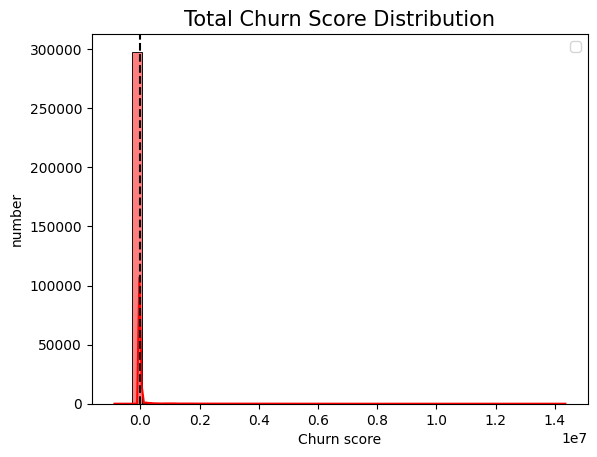

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 종합 이탈 점수 분포 (Histogram & KDE)
sns.histplot(df_final['종합이탈점수'], bins=50, kde=True, color='red')
plt.title('Total Churn Score Distribution', fontsize=15)
plt.xlabel('Churn score')
plt.ylabel('number')
plt.axvline(x=50, color='black', linestyle='--')
plt.legend()

Total Customers: 300000
Zero Score Customers: 49925 (16.6%)


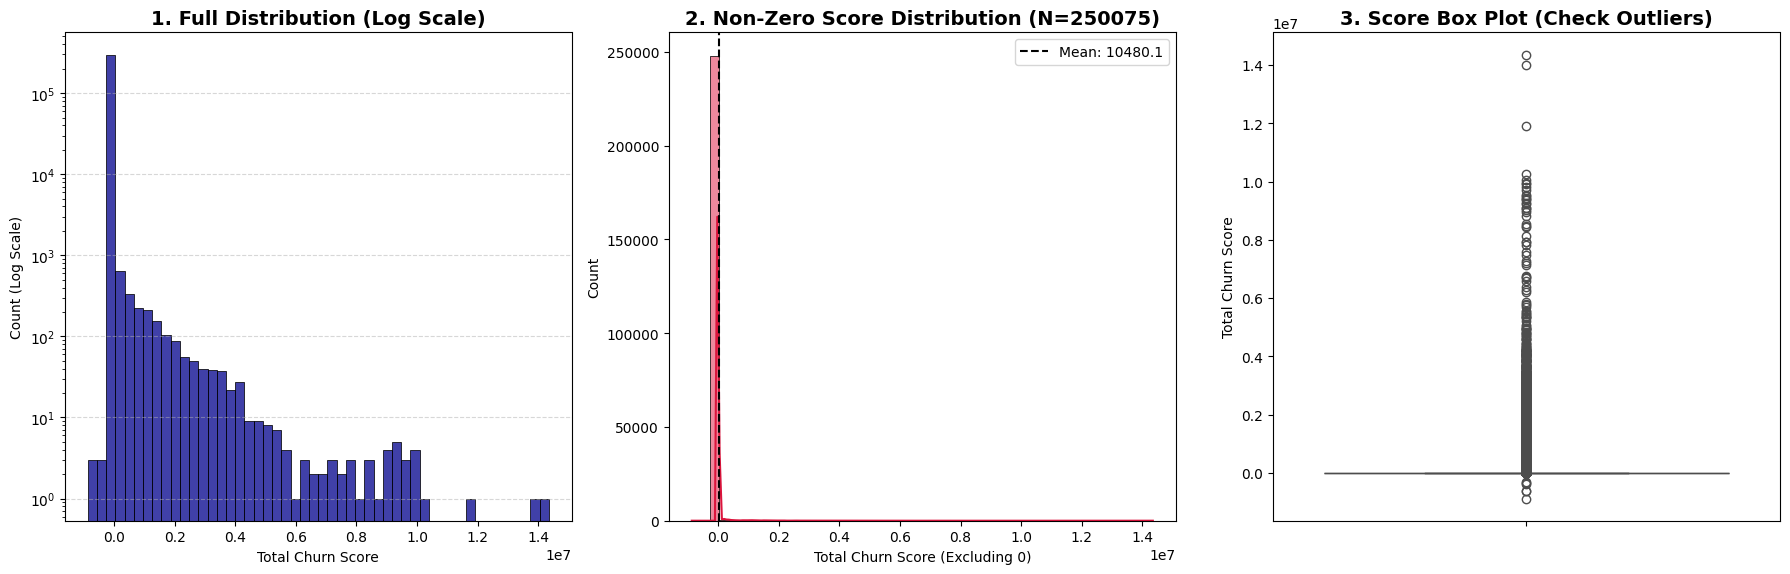

In [ ]:
# -----------------------------------------------------------
# [1] 데이터 준비 (df_final이 이미 생성되었다고 가정)
# -----------------------------------------------------------
# 0점인 사람과 0점이 아닌 사람 분리
df_nonzero = df_final[df_final['종합이탈점수'] != 0]
zero_count = len(df_final) - len(df_nonzero)
zero_ratio = (zero_count / len(df_final)) * 100

print(f"Total Customers: {len(df_final)}")
print(f"Zero Score Customers: {zero_count} ({zero_ratio:.1f}%)")

# -----------------------------------------------------------
# [2] 시각화 생성 (Focus on Score Distribution)
# -----------------------------------------------------------
plt.figure(figsize=(18, 6))

# [Plot 1] 전체 분포 (Y축 로그 스케일 적용)
# 0점이 너무 많을 때 막대 높이 차이를 줄여서 낮은 빈도도 보이게 함
plt.subplot(1, 3, 1)
sns.histplot(df_final['종합이탈점수'], bins=50, color='darkblue', kde=False)
plt.yscale('log')  # <--- 핵심: 로그 스케일 적용
plt.title('1. Full Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Total Churn Score')
plt.ylabel('Count (Log Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# [Plot 2] 0점 제외 분포 (Zoom-In)
# 실제 점수가 발생한 고객들만 따로 떼어내어 분포 확인
plt.subplot(1, 3, 2)
if not df_nonzero.empty:
    sns.histplot(df_nonzero['종합이탈점수'], bins=50, kde=True, color='crimson')
    plt.title(f'2. Non-Zero Score Distribution (N={len(df_nonzero)})', fontsize=14, fontweight='bold')
    plt.xlabel('Total Churn Score (Excluding 0)')
    plt.ylabel('Count')
    # 평균선 표시
    plt.axvline(df_nonzero['종합이탈점수'].mean(), color='black', linestyle='--', label=f"Mean: {df_nonzero['종합이탈점수'].mean():.1f}")
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No Non-Zero Scores', ha='center', va='center')

# [Plot 3] 상자 수염 그림 (Box Plot)
# 이상치(Outlier)와 4분위수를 확인하여 극단적인 고위험군 파악
plt.subplot(1, 3, 3)
sns.boxplot(y=df_final['종합이탈점수'], color='orange')
plt.title('3. Score Box Plot (Check Outliers)', fontsize=14, fontweight='bold')
plt.ylabel('Total Churn Score')

plt.tight_layout()
plt.show()